# COVID-19 Infection curve analysis                                                                      
## Naoaki ONO nono@is.nasit.jp   

CoViD-19 infection curve (in Japan, from Jan. 15, 2020) analysis using R.

The numbers of infected and tested by PCR have been gathered from the website of Ministry of Health, Labour and Welfare, Japan

Sources and data are available on GitHub.
https://github.com/naono-git/covid19

Open using [nbviewer service](https://nbviewer.jupyter.org/github/naono-git/covid19/tree/master/covid19.ipynb)


In [1]:
library(date)
source("src/plotUtil.R")

In [99]:
covid <- read.delim("data/covid19.txt", header=TRUE, sep="\t")
nd <- nrow(covid)

covid.kyoto <- read.delim("data/covid19.kyoto.txt", header=TRUE, sep="\t")
covid.osaka <- read.delim("data/covid19.osaka.txt", header=TRUE, sep="\t")
covid.nara <- read.delim("data/covid19.nara.txt", header=TRUE, sep="\t")
covid.hyogo <- read.delim("data/covid19.hyogo.txt", header=TRUE, sep="\t")

population4 <- c(kyoto=2599, osaka=8823, nara=1348, hyogo=5503)

stamp <- paste(c(covid[nd,1],sprintf("%02d",covid[nd,2]),sprintf("%02d",covid[nd,3])),collapse="")
stamp

[1] "20200401"

In [100]:
ddd <- mdy.date(month=covid$mm, day=covid$dd, year=covid$yy)
d0  <- ddd[1]
dd1 <- ddd-d0 ## relative date starting from 2020/01/15                                                   
dd1[1] <- 7   ## initial offset (aribtrary chosen) 

In [139]:
## dates to plot ticks                                                                                    
mdlabel <- rbind(c(1,15),
                 c(2, 1),
                 c(2,15),
                 c(3, 1),
                 c(3,15),
                 c(4, 1),
                 c(4,15),
                 c(5, 1)
                )
ddlabel <- apply(mdlabel,1,function(xx){
    mdy.date(xx[1],xx[2],2020)
})
## label to plot ticks                                                                                    
ticklabel <- apply(mdlabel,1,paste,collapse="/")

In [140]:
logd <- log(dd1)        ## log day
logi <- log(covid$i)    ## log number of infected                                                               
logp <- log(covid$PCR)  ## log number of PCR

In [141]:
daydiff <- function(xx){
    return(xx - c(0,xx[-length(xx)]))
}
pred_pow <- function(xx,cc,ll){
    return(xx^ll*exp(cc))
}
pred_exp <- function(xx,cc,ll){
    return(cc*exp(ll*xx))
}

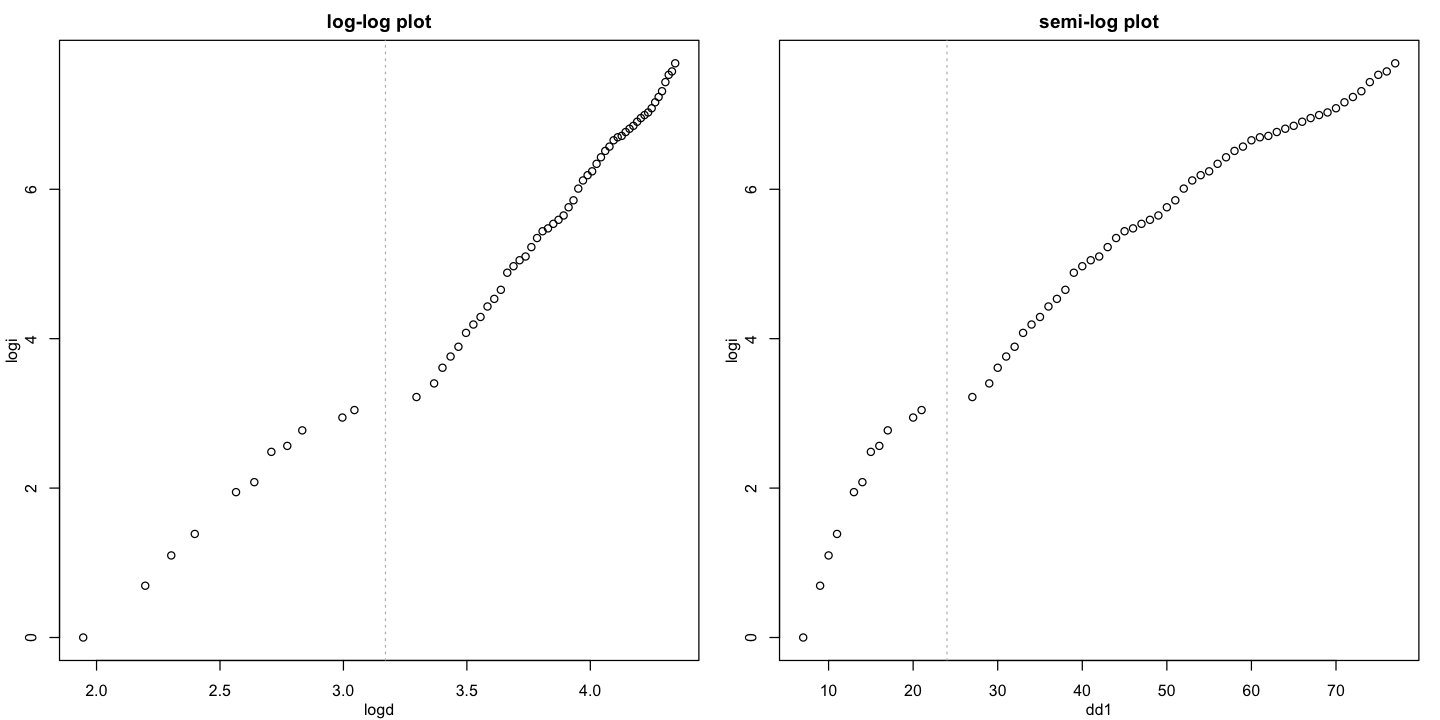

In [142]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfcol=c(1,2))
par.margin("smart")

plot(logd, logi, main="log-log plot")
abline(v=mean(logd[11:12]), lty=3, col=8)
# abline(-2,2,lty=3, col=2)

plot(dd1, logi, main="semi-log plot")
abline(v=mean(dd1[11:12]), lty=3, col=8)
## ... Do you think which looks more linearly?

In [143]:
## Fitting by power. 1, fit for the earlier stage                                                   
model_pow_0 <- lm(logi~logd)
model_pow_0

model_pow_1 <- lm(logi[1:11]~logd[1:11])
model_pow_1

## Fitting by power. 2, fit for the latter stage                                                   
model_pow_2 <- lm(logi[12:nd]~logd[12:nd])
model_pow_2


Call:
lm(formula = logi ~ logd)

Coefficients:
(Intercept)         logd  
     -6.556        3.176  



Call:
lm(formula = logi[1:11] ~ logd[1:11])

Coefficients:
(Intercept)   logd[1:11]  
     -5.562        2.894  



Call:
lm(formula = logi[12:nd] ~ logd[12:nd])

Coefficients:
(Intercept)  logd[12:nd]  
    -11.565        4.466  


In general, the dynamics of infection is described by the "SIR" model.
$$
\frac{dS}{dt} = -\beta IS \\
\frac{dI}{dt} = \beta IS - \gamma I \\
\frac{dR}{dt} = \gamma I,
$$
where S denotes the population ratio of susceptible, I denotes infected, R denotes recoverd, respectively, and $\beta$ and $\gamma$ are the coefficient of infection and recovery.

Where the growth looks linear in the semi-log prot, we can expect the simplest growth dynamics,

$$
\frac{dI}{dt} = \lambda I \\
I(t) = I_0 \exp(\lambda t) \\
\log(I) = \lambda t + C_0
$$



In [144]:
## We focus on the latter growth (D > Feb. 11th)
model_exp_2 <- lm(logi[12:nd]~dd1[12:nd])
model_exp_2
cc_exp_2 <- exp(model_exp_2$coefficients[1])
ll_exp_2 <- model_exp_2$coefficients[2]


Call:
lm(formula = logi[12:nd] ~ dd1[12:nd])

Coefficients:
(Intercept)   dd1[12:nd]  
   -0.04666      0.12313  


In [145]:
dim(covid.osaka)

[1] 34  6

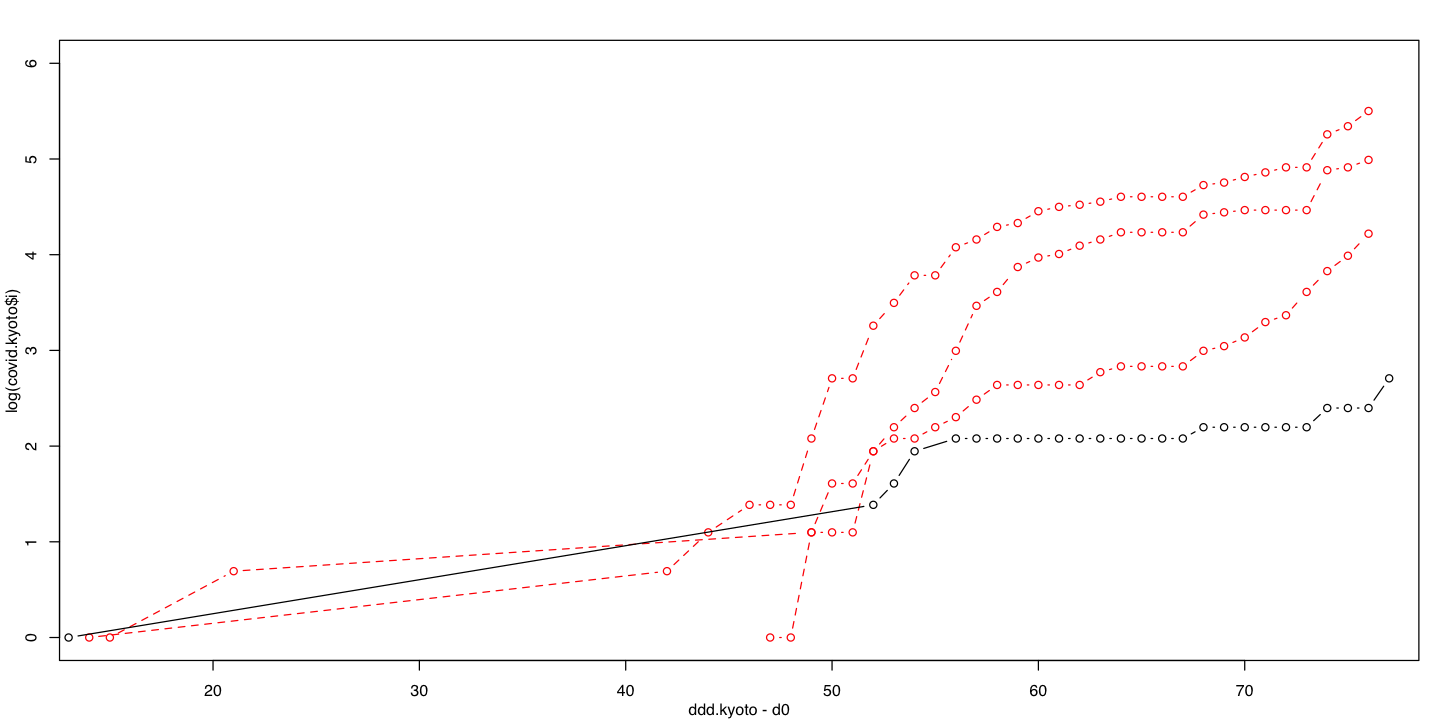

In [146]:
ddd.kyoto <- mdy.date(month=covid.kyoto$mm, day=covid.kyoto$dd, year=covid.kyoto$yy)
ddd.osaka <- mdy.date(month=covid.osaka$mm, day=covid.osaka$dd, year=covid.osaka$yy)
ddd.nara  <- mdy.date(month=covid.nara$mm,  day=covid.nara$dd,  year=covid.nara$yy )
ddd.hyogo <- mdy.date(month=covid.hyogo$mm, day=covid.hyogo$dd, year=covid.hyogo$yy)
logi.nara <- log(covid.nara$i)
plotFigure(function(){
    par.margin("smart")
    plot(  ddd.kyoto-d0, log(covid.kyoto$i), type="b", col=2, lty=2, ylim=c(0,6))
    points(ddd.osaka-d0, log(covid.osaka$i), type="b", col=2, lty=2)
    points(ddd.hyogo-d0, log(covid.hyogo$i), type="b", col=2, lty=2)
    points(ddd.nara -d0, log(covid.nara$i ), type="b")
})

In [147]:

tmp.nara  <- optimize(function(par){ mean( (exp((ddd.nara-d0 )*ll_exp_2+par) - covid.nara$i )^2)}, c(-5,5))
exp(tmp.nara$minimum )


[1] 0.00673828

In [151]:
dd <- 14
covid3 <- list(kyoto=covid.kyoto, osaka=covid.osaka, nara=covid.nara, hyogo=covid.hyogo)
source3 <- c("kyoto","osaka","hyogo")
ll3 <- numeric(3)
for(aa in 1:3){
    ss <- source3[aa]
    covid_tmp <- covid3[[ss]]

    nd <- nrow(covid_tmp)
    ddd_tmp <- mdy.date(month=covid_tmp$mm, day=covid_tmp$dd, year=covid_tmp$yy)
    xx <- ddd_tmp[(nd-dd):nd]
    yy <- log(covid_tmp$i[(nd-dd):nd])
    tmp <- lm(yy~xx)    
    ll3[aa] <- tmp$coefficients[2]
}
ll_mean <- sum(ll3 * population4[c("kyoto", "osaka", "hyogo")]) /sum(population4[c("kyoto", "osaka", "hyogo")])
ll_mean

lambda <- 0.2
ll_tmp <- ll_mean*(1-lambda)+ll_exp_2[[1]]*lambda
ll_tmp

[1] 0.06750597

[1] 0.07863022

In [152]:
tmp.nara <- optimize(function(par){ mean( (exp((ddd.nara-d0 )*ll_tmp+par) - covid.nara$i )^2)}, c(-5,5))
tmp.nara
cc_tmp <- exp(tmp.nara$minimum)

$minimum
[1] -3.27974

$objective
[1] 7.832275

In [153]:
# prediction of number of infected
pred.nara <- cbind(mdlabel, round(pred_exp(ddlabel-d0, cc_tmp, ll_tmp)))
colnames(pred.nara) <- c("MM","DD","Predicted")
print(pred.nara)

     MM DD Predicted
[1,]  1 15         0
[2,]  2  1         0
[3,]  2 15         0
[4,]  3  1         1
[5,]  3 15         4
[6,]  4  1        16
[7,]  4 15        48
[8,]  5  1       170


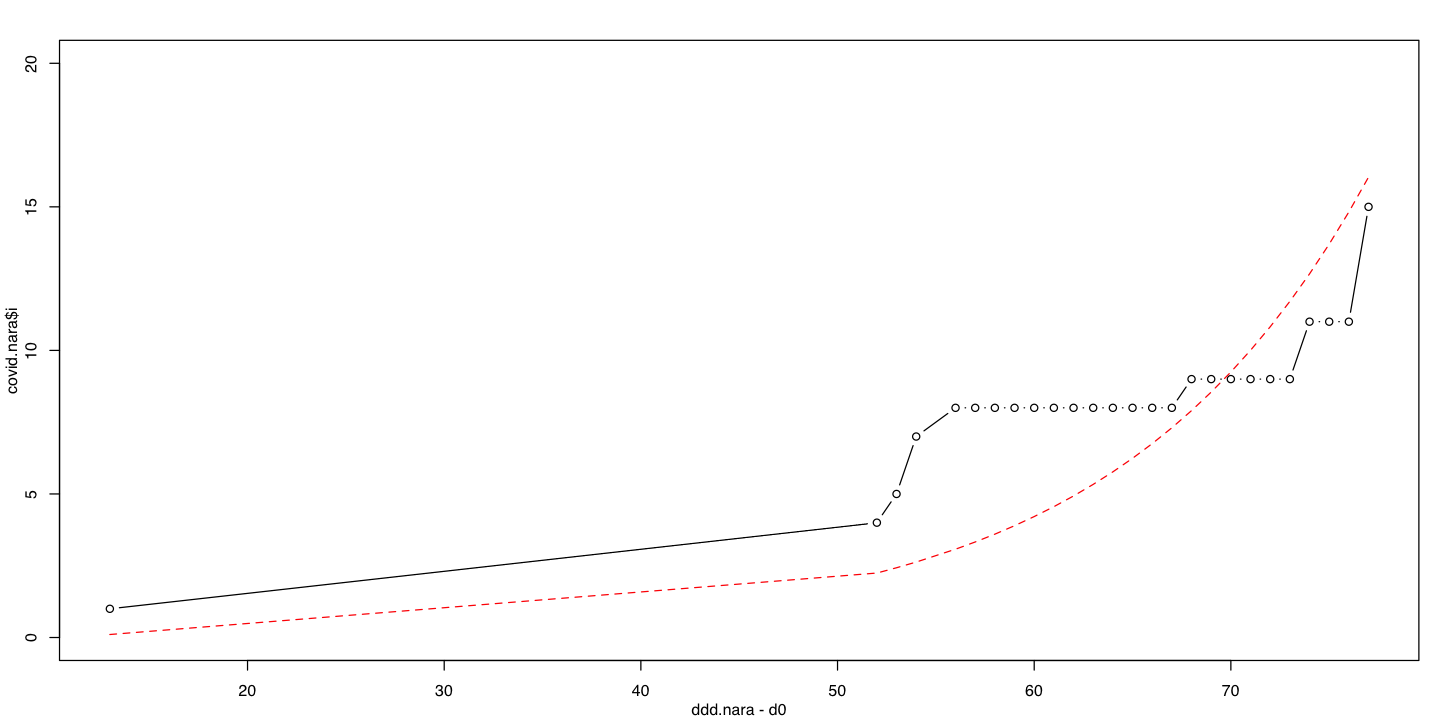

In [154]:
pred.nara <- pred_exp(ddd.nara-d0, cc_tmp, ll_tmp)

plotFigure(function(){
    plot(ddd.nara-d0, covid.nara$i, ylim=c(0,20), type="b")
    points(ddd.nara-d0, pred.nara, type="l",lty=2,col=2)    
})


In [ ]:
nn <- 1348
